# Data Preparation

In [2]:
pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 22.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

from keras import layers, ops
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout,  Input, Flatten, Layer

import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.callbacks import ModelCheckpoint

# Prepare the data

In [4]:
num_classes = 10
input_shape = (28, 28, 1)

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train = X_train.reshape(60000, 28,28,1)
X_test = X_test.reshape(10000, 28,28,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)
Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


# Configure the hyperparameters

In [36]:
#learning_rate = 0.001
#weight_decay = 0.0001
batch_size = 256
num_epochs = 3  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
num_heads = 4
d_QK = 16
projection_dim = d_QK * num_heads # d, ensure"encoded_patch, attention output same dim
nb_random_features = 16 # m
window_size = 12 # to be used in local attention (querying the closest 2 * window_size tokens)
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    256,
    128,
]  # Size of the dense layers of the final classifier


# Data augmentation

In [6]:
data_augmentation = Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

#Implement multilayer perceptron (MLP)

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implement patch creation as a layer

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        #input_shape = images.shape
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size, # sample dimension
                num_patches_h * num_patches_w, # patch dimension
                self.patch_size * self.patch_size * channels, # patch encoding
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

(1, 28, 28, 1)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36


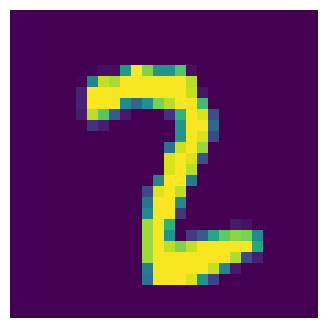

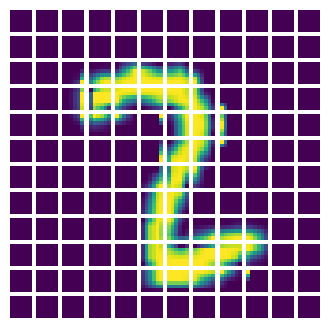

In [9]:
# display some patches

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
#plt.imshow(image.astype("uint8"))
plt.imshow(image)
plt.axis("off")

print(ops.convert_to_tensor([image]).shape)
resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 1))
    #plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.imshow(ops.convert_to_numpy(patch_img))
    plt.axis("off")

# Implement the patch encoding layer

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

# Run ViT Model

In [31]:
def create_vit_classifier():
    inputs = Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches) #(N, n_patches, patch_size)
        # Create a multi-head attention layer.
        #attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)

        attention_output = Attention(num_heads = num_heads,
                                     hidden_size = projection_dim,
                                     attention_dropout = 0.1,
                                     kernel_transformation=relu_kernel_transformation,
                                     projection_matrix_type = 1,
                                     #causal = True,
                                     local = True,
                                     window_size = window_size,
                                     nb_random_features = nb_random_features)(x1, x1, tf.ones([1]))

        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    #logits = layers.Dense(num_classes)(features)
    outputs = layers.Dense(num_classes, activation='softmax')(features)
    # Create the Keras model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

Epoch 1/3
211/211 ━━━━━━━━━━━━━━━━━━━━ 1011s 3s/step - accuracy: 0.4106 - loss: 1.9720 - val_accuracy: 0.8248 - val_loss: 0.5746
Epoch 2/3
211/211 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step - accuracy: 0.6883 - loss: 0.9630 - val_accuracy: 0.8900 - val_loss: 0.3706
Epoch 3/3
211/211 ━━━━━━━━━━━━━━━━━━━━ 623s 3s/step - accuracy: 0.7699 - loss: 0.6902 - val_accuracy: 0.9187 - val_loss: 0.3048
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step - accuracy: 0.8875 - loss: 0.3560
Test accuracy: 90.6%


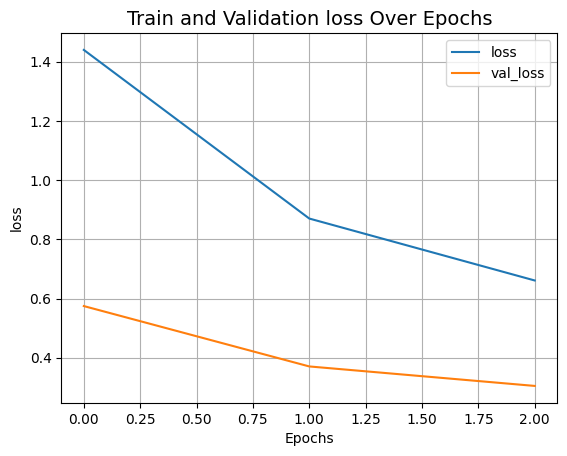

In [37]:
def run_experiment(model):
    #optimizer = keras.optimizers.AdamW(
        #learning_rate=learning_rate, weight_decay=weight_decay
    #)

    model.compile(
        #optimizer=optimizer,
        optimizer = 'adam',
        #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        loss = 'categorical_crossentropy',
        metrics=[
            'accuracy'
            #keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            #keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    #_, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    _, accuracy = model.evaluate(X_test, Y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
#plot_history("top-5-accuracy")

# FAST_ATTENTION

In [20]:
BIG_CONSTANT = 1e8


def create_projection_matrix(m, d, seed=0, scaling=0, struct_mode=False):
  r"""Constructs the matrix of random projections.

  Constructs a matrix of random orthogonal projections. Each projection vector
  has direction chosen uniformly at random and either deterministic length
  \sqrt{d} or length taken from the \chi(d) distribution (in the latter case
  marginal distributions of the projections are d-dimensional Gaussian vectors
  with associated identity covariance matrix).

  Args:
    m: number of random projections.
    d: dimensionality of each random projection.
    seed: random seed used to construct projections.
    scaling: 1 if all the random projections need to be renormalized to have
      length \sqrt{d}, 0 if the lengths of random projections should follow
      \chi(d) distribution.
    struct_mode: if True then products of Givens rotations will be used to
      construct random orthogonal matrix. This bypasses Gram-Schmidt
      orthogonalization.

  Returns:
    The matrix of random projections of the shape [m, d].
  """
  nb_full_blocks = int(m / d)
  block_list = []
  current_seed = seed
  for _ in range(nb_full_blocks):
    if struct_mode:
      q = create_products_of_givens_rotations(d, seed)
    else:
      unstructured_block = tf.random.normal((d, d), seed=current_seed)
      q, _ = tf.linalg.qr(unstructured_block)
      q = tf.transpose(q)
    block_list.append(q)
    current_seed += 1
  remaining_rows = m - nb_full_blocks * d
  if remaining_rows > 0:
    if struct_mode:
      q = create_products_of_givens_rotations(d, seed)
    else:
      unstructured_block = tf.random.normal((d, d), seed=current_seed)
      q, _ = tf.linalg.qr(unstructured_block)
      q = tf.transpose(q)
    block_list.append(q[0:remaining_rows])
  final_matrix = tf.experimental.numpy.vstack(block_list)
  current_seed += 1

  if scaling == 0:
    multiplier = tf.norm(tf.random.normal((m, d), seed=current_seed), axis=1)
  elif scaling == 1:
    multiplier = tf.math.sqrt(float(d)) * tf.ones((m))
  else:
    raise ValueError("Scaling must be one of {0, 1}. Was %s" % scaling)

  return tf.linalg.matmul(tf.linalg.diag(multiplier), final_matrix)


def create_products_of_givens_rotations(dim, seed):
  r"""Constructs a 2D-tensor which is a product of Givens random rotations.

  Constructs a 2D-tensor of the form G_1 * ... * G_k, where G_i is a Givens
  random rotation. The resulting tensor mimics a matrix taken uniformly at
  random form the orthogonal group.

  Args:
    dim: number of rows/columns of the resulting 2D-tensor.
    seed: random seed.

  Returns:
    The product of Givens random rotations.
  """
  nb_givens_rotations = dim * int(math.ceil(math.log(float(dim))))
  q = np.eye(dim, dim)
  np.random.seed(seed)
  for _ in range(nb_givens_rotations):
    random_angle = math.pi * np.random.uniform()
    random_indices = np.random.choice(dim, 2)
    index_i = min(random_indices[0], random_indices[1])
    index_j = max(random_indices[0], random_indices[1])
    slice_i = q[index_i]
    slice_j = q[index_j]
    new_slice_i = math.cos(random_angle) * slice_i + math.sin(
        random_angle) * slice_j
    new_slice_j = -math.sin(random_angle) * slice_i + math.cos(
        random_angle) * slice_j
    q[index_i] = new_slice_i
    q[index_j] = new_slice_j
  return tf.cast(tf.constant(q), dtype=tf.float32)


def relu_kernel_transformation(data,
                               is_query,
                               projection_matrix=None,
                               numerical_stabilizer=0.001):
  """Computes features for the ReLU-kernel.

  Computes random features for the ReLU kernel from
  https://arxiv.org/pdf/2009.14794.pdf.

  Args:
    data: input data tensor of the shape [B, L, H, D], where: B - batch
      dimension, L - attention dimensions, H - heads, D - features.
    is_query: indicates whether input data is a query oor key tensor.
    projection_matrix: random Gaussian matrix of shape [M, D], where M stands
      for the number of random features and each D x D sub-block has pairwise
      orthogonal rows.
    numerical_stabilizer: small positive constant for numerical stability.

  Returns:
    Corresponding kernel feature map.
  """
  del is_query
  if projection_matrix is None:
    return tf.nn.relu(data) + numerical_stabilizer
  else:
    ratio = 1.0 / tf.math.sqrt(
        tf.dtypes.cast(projection_matrix.shape[0], tf.float32))
    data_dash = ratio * tf.einsum("blhd,md->blhm", data, projection_matrix)
    return tf.nn.relu(data_dash) + numerical_stabilizer


def softmax_kernel_transformation(data,
                                  is_query,
                                  projection_matrix=None,
                                  numerical_stabilizer=0.000001):
  """Computes random features for the softmax kernel using FAVOR+ mechanism.

  Computes random features for the softmax kernel using FAVOR+ mechanism from
  https://arxiv.org/pdf/2009.14794.pdf.

  Args:
    data: input data tensor of the shape [B, L, H, D], where: B - batch
      dimension, L - attention dimensions, H - heads, D - features.
    is_query: indicates whether input data is a query oor key tensor.
    projection_matrix: random Gaussian matrix of shape [M, D], where M stands
      for the number of random features and each D x D sub-block has pairwise
      orthogonal rows.
    numerical_stabilizer: small positive constant for numerical stability.

  Returns:
    Corresponding kernel feature map.
  """
  data_normalizer = 1.0 / (
      tf.math.sqrt(tf.math.sqrt(tf.dtypes.cast(data.shape[-1], tf.float32))))
  data = data_normalizer * data
  ratio = 1.0 / tf.math.sqrt(
      tf.dtypes.cast(projection_matrix.shape[0], tf.float32))
  data_dash = tf.einsum("blhd,md->blhm", data, projection_matrix)
  diag_data = tf.math.square(data)
  diag_data = tf.math.reduce_sum(
      diag_data, axis=tf.keras.backend.ndim(data) - 1)
  diag_data = diag_data / 2.0
  diag_data = tf.expand_dims(diag_data, axis=tf.keras.backend.ndim(data) - 1)
  last_dims_t = (len(data_dash.shape) - 1,)
  attention_dims_t = (len(data_dash.shape) - 3,)
  if is_query:
    data_dash = ratio * (
        tf.math.exp(data_dash - diag_data - tf.math.reduce_max(
            data_dash, axis=last_dims_t, keepdims=True)) + numerical_stabilizer)
  else:
    data_dash = ratio * (
        tf.math.exp(data_dash - diag_data - tf.math.reduce_max(
            data_dash, axis=last_dims_t + attention_dims_t, keepdims=True)) +
        numerical_stabilizer)

  return data_dash


def noncausal_numerator(qs, ks, vs):
  """Computes not-normalized FAVOR noncausal attention AV.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].
    vs: value tensor of the shape [L,B,H,D].

  Returns:
    Not-normalized FAVOR noncausal attention AV.
  """
  kvs = tf.einsum("lbhm,lbhd->bhmd", ks, vs)
  return tf.einsum("lbhm,bhmd->lbhd", qs, kvs)


def noncausal_denominator(qs, ks):
  """Computes FAVOR normalizer in noncausal attention.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].

  Returns:
    FAVOR normalizer in noncausal attention.
  """
  all_ones = tf.ones([ks.shape[0]])
  ks_sum = tf.einsum("lbhm,l->bhm", ks, all_ones)
  return tf.einsum("lbhm,bhm->lbh", qs, ks_sum)





@tf.custom_gradient
def causal_numerator(qs, ks, vs):
  """Computes not-normalized FAVOR causal attention A_{masked}V.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].
    vs: value tensor of the shape [L,B,H,D].

  Returns:
    Not-normalized FAVOR causal attention A_{masked}V.
  """

  result = []
  sums = tf.zeros_like(tf.einsum("ijk,ijl->ijkl", ks[0], vs[0])) #(B, H, M, D)
  #ks[0] shape (None, num_heads, m)

  for index in range(qs.shape[0]):
    sums = sums + tf.einsum("ijk,ijl->ijkl", ks[index], vs[index])
    result.append(tf.einsum("ijkl,ijk->ijl", sums, qs[index])[None, Ellipsis])

  result = tf.concat(result, axis=0)

  def grad(res_grad):

    grads = tf.zeros_like(tf.einsum("ijk,ijl->ijkl", ks[0], vs[0]))

    gr_sums = sums

    q_grads = []
    k_grads = []
    v_grads = []

    for index in range(qs.shape[0] - 1, -1, -1):

      q_grads.append(
          tf.einsum("ijkl,ijl->ijk", gr_sums, res_grad[index])[None, Ellipsis])
      grads = grads + tf.einsum("ijk,ijl->ijkl", qs[index], res_grad[index])
      k_grads.append(tf.einsum("ijkl,ijl->ijk", grads, vs[index])[None, Ellipsis])
      v_grads.append(tf.einsum("ijkl,ijk->ijl", grads, ks[index])[None, Ellipsis])
      gr_sums = gr_sums - tf.einsum("ijk,ijl->ijkl", ks[index], vs[index])

    q_grads = tf.concat(q_grads[::-1], axis=0)
    k_grads = tf.concat(k_grads[::-1], axis=0)
    v_grads = tf.concat(v_grads[::-1], axis=0)

    return q_grads, k_grads, v_grads

  return result, grad


@tf.custom_gradient
def causal_denominator(qs, ks):
  """Computes FAVOR normalizer in causal attention.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].

  Returns:
    FAVOR normalizer in causal attention.
  """

  result = []
  sums = tf.zeros_like(ks[0])

  for index in range(qs.shape[0]):
    sums = sums + ks[index]
    result.append(tf.reduce_sum(qs[index] * sums, axis=2)[None, Ellipsis])

  result = tf.concat(result, axis=0)

  def grad(res_grad):

    k_grad = tf.zeros_like(ks[0])

    gr_sums = sums

    q_grads = []
    k_grads = []

    for index in range(qs.shape[0] - 1, -1, -1):

      q_grads.append(tf.einsum("ijk,ij->ijk", gr_sums, res_grad[index])[None, Ellipsis])
      k_grad = k_grad + tf.einsum("ijk,ij->ijk", qs[index], res_grad[index])
      k_grads.append(k_grad[None, Ellipsis])
      gr_sums = gr_sums - ks[index]

    q_grads = tf.concat(q_grads[::-1], axis=0)
    k_grads = tf.concat(k_grads[::-1], axis=0)

    return q_grads, k_grads

  return result, grad


@tf.custom_gradient
def local_numerator(qs, ks, vs):
  """Computes not-normalized FAVOR local attention A_{masked}V.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].
    vs: value tensor of the shape [L,B,H,D].
    implicit window_size

  Returns:
    Not-normalized FAVOR local attention A_{masked}V.
  """

  result = []

  tmp = []
  for index in range(qs.shape[0]):
    tmp.append(tf.expand_dims(tf.einsum("ijk,ijl->ijkl", ks[index], vs[index]), axis = 0))
  tmp = tf.concat(tmp, axis = 0)

  sums = tf.reduce_sum(tmp[:window_size + 1], axis = 0)
  for index in range(qs.shape[0]):
    result.append(tf.einsum("ijkl,ijk->ijl", sums, qs[index])[None, Ellipsis])
    if index + window_size + 1 < qs.shape[0]:
      sums = sums + tmp[index + window_size + 1]
    if index - window_size >= 0:
      sums = sums - tmp[index - window_size]

  '''
  mask = [True] * (window_size + 1) + [False] * (qs.shape[0] - window_size - 1)
  mask = np.array(mask)
  for index in range(qs.shape[0]):
    sums = tf.boolean_mask(tmp, mask, axis = 0)
    sums = tf.reduce_sum(sums, axis = 0)
    if index + window_size + 1 < qs.shape[0]:
      mask[index + window_size + 1] = True
    if index - window_size >= 0:
      mask[index - window_size] = False
    result.append(tf.einsum("ijkl,ijk->ijl", sums, qs[index])[None, Ellipsis])
  '''

  result = tf.concat(result, axis=0)

  def grad(res_grad):

    q_grads = []
    k_grads = []
    v_grads = []

    tmp = []
    for index in range(qs.shape[0]):
      tmp.append(tf.expand_dims(tf.einsum("ijk,ijl->ijkl", ks[index], vs[index]), axis = 0))
    tmp = tf.concat(tmp, axis = 0)

    # q grads
    sums = tf.reduce_sum(tmp[:window_size + 1], axis = 0)
    for index in range(qs.shape[0]):
      q_grads.append(tf.einsum("ijkl,ijl->ijk", sums, res_grad[index])[None, Ellipsis])
      if index + window_size + 1 < qs.shape[0]:
        sums = sums + tmp[index + window_size + 1]
      if index - window_size >= 0:
        sums = sums - tmp[index - window_size]

    # k and v grads
    tmp = []
    for index in range(qs.shape[0]):
      tmp.append(tf.expand_dims(tf.einsum("ijk,ijl->ijkl", qs[index], res_grad[index]), axis = 0))
    tmp = tf.concat(tmp, axis = 0)

    sums = tf.reduce_sum(tmp[:window_size + 1], axis = 0)
    for index in range(qs.shape[0]):
      k_grads.append(tf.einsum("ijkl,ijl->ijk", sums, vs[index])[None, Ellipsis])
      v_grads.append(tf.einsum("ijkl,ijk->ijl", sums, ks[index])[None, Ellipsis])
      if index + window_size + 1 < qs.shape[0]:
        sums = sums + tmp[index + window_size + 1]
      if index - window_size >= 0:
        sums = sums - tmp[index - window_size]


    '''
    # q grads, assume tmp stays the way it is
    mask = [True] * (window_size + 1) + [False] * (qs.shape[0] - window_size - 1)
    mask = np.array(mask)
    for index in range(qs.shape[0]):
      sums = tf.boolean_mask(tmp, mask, axis = 0)
      sums = tf.reduce_sum(sums, axis = 0)
      if index + window_size + 1 < qs.shape[0]:
        mask[index + window_size + 1] = True
      if index - window_size >= 0:
        mask[index - window_size] = False
      q_grads.append(tf.einsum("ijkl,ijl->ijk", sums, res_grad[index])[None, Ellipsis])

    # k and v grads
    tmp = []
    for index in range(qs.shape[0]):
      tmp.append(tf.expand_dims(tf.einsum("ijk,ijl->ijkl", qs[index], res_grad[index]), axis = 0))
    tmp = tf.concat(tmp, axis = 0)

    mask = [True] * (window_size + 1) + [False] * (qs.shape[0] - window_size - 1)
    mask = np.array(mask)
    for index in range(qs.shape[0]):
      sums = tf.boolean_mask(tmp, mask, axis = 0)
      sums = tf.reduce_sum(sums, axis = 0)
      if index + window_size + 1 < qs.shape[0]:
        mask[index + window_size + 1] = True
      if index - window_size >= 0:
        mask[index - window_size] = False
      k_grads.append(tf.einsum("ijkl,ijl->ijk", sums, vs[index])[None, Ellipsis])
      v_grads.append(tf.einsum("ijkl,ijk->ijl", sums, ks[index])[None, Ellipsis])

    '''

    q_grads = tf.concat(q_grads, axis=0)
    k_grads = tf.concat(k_grads, axis=0)
    v_grads = tf.concat(v_grads, axis=0)

    return q_grads, k_grads, v_grads

  return result, grad




@tf.custom_gradient
def local_denominator(qs, ks):
  """Computes FAVOR normalizer in causal attention.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].

  Returns:
    FAVOR normalizer in causal attention.
  """

  result = []

  sums = tf.reduce_sum(ks[:window_size + 1], axis = 0)
  for index in range(qs.shape[0]):
    result.append(tf.reduce_sum(qs[index] * sums, axis=2)[None, Ellipsis])
    if index + window_size + 1 < qs.shape[0]:
      sums = sums + ks[index + window_size + 1]
    if index - window_size >= 0:
      sums = sums - ks[index - window_size]

  result = tf.concat(result, axis=0)

  def grad(res_grad):

    q_grads = []
    k_grads = []

    # q grads
    sums = tf.reduce_sum(ks[:window_size + 1], axis = 0)
    for index in range(qs.shape[0]):
      q_grads.append(tf.einsum("ijk,ij->ijk", sums, res_grad[index])[None, Ellipsis])
      if index + window_size + 1 < qs.shape[0]:
        sums = sums + ks[index + window_size + 1]
      if index - window_size >= 0:
        sums = sums - ks[index - window_size]

    # k grads
    tmp = []
    for index in range(qs.shape[0]):
      tmp.append(tf.expand_dims(tf.einsum("ijk,ij->ijk", qs[index], res_grad[index]), axis = 0))
    tmp = tf.concat(tmp, axis = 0)

    sums = tf.reduce_sum(tmp[:window_size + 1], axis = 0)
    for index in range(qs.shape[0]):
      k_grads.append(sums[None, Ellipsis])
      if index + window_size + 1 < qs.shape[0]:
        sums = sums + tmp[index + window_size + 1]
      if index - window_size >= 0:
        sums = sums - tmp[index - window_size]

    """
    for index in range(qs.shape[0] - 1, -1, -1):

      q_grads.append(tf.einsum("ijk,ij->ijk", gr_sums, res_grad[index])[None, Ellipsis])
      k_grad = k_grad + tf.einsum("ijk,ij->ijk", qs[index], res_grad[index])
      k_grads.append(k_grad[None, Ellipsis])
      gr_sums = gr_sums - ks[index]
    """

    q_grads = tf.concat(q_grads, axis=0)
    k_grads = tf.concat(k_grads, axis=0)

    return q_grads, k_grads

  return result, grad





def favor_attention(query,
                    key,
                    value,
                    kernel_transformation,
                    causal,
                    local=False,
                    window_size=None,
                    projection_matrix=None):
  """Computes FAVOR normalized attention.

  Args:
    query: query tensor.
    key: key tensor.
    value: value tensor.
    kernel_transformation: transformation used to get finite kernel features.
    causal: whether attention is causal or not.
    projection_matrix: projection matrix to be used.

  Returns:
    FAVOR normalized attention.
  """
  query_prime = kernel_transformation(query, True,
                                      projection_matrix)  # [B,L,H,M]
  key_prime = kernel_transformation(key, False, projection_matrix)  # [B,L,H,M]
  query_prime = tf.transpose(query_prime, [1, 0, 2, 3])  # [L,B,H,M]
  key_prime = tf.transpose(key_prime, [1, 0, 2, 3])  # [L,B,H,M]
  value = tf.transpose(value, [1, 0, 2, 3])  # [L,B,H,D]

  if causal:
    av_attention = causal_numerator(query_prime, key_prime, value)
    attention_normalizer = causal_denominator(query_prime, key_prime)
  elif local:
    av_attention = local_numerator(query_prime, key_prime, value)
    attention_normalizer = local_denominator(query_prime, key_prime)
  else:
    av_attention = noncausal_numerator(query_prime, key_prime, value)
    attention_normalizer = noncausal_denominator(query_prime, key_prime)
  # TODO(kchoro): Add more comments.
  av_attention = tf.transpose(av_attention, [1, 0, 2, 3])
  attention_normalizer = tf.transpose(attention_normalizer, [1, 0, 2])
  attention_normalizer = tf.expand_dims(attention_normalizer,
                                        len(attention_normalizer.shape))
  return av_attention / attention_normalizer


class Attention(tf.keras.layers.Layer):
  """Multi-headed attention layer."""

  def __init__(self,
               hidden_size,
               num_heads,
               attention_dropout,
               kernel_transformation=relu_kernel_transformation,
               numerical_stabilizer=0.001,
               causal=False,
               local=False,
               window_size=None,
               projection_matrix_type=None,
               nb_random_features=0):

    """Initialize Attention.

    Args:
      hidden_size: int, output dim of hidden layer.
      num_heads: int, number of heads to repeat the same attention structure.
      attention_dropout: float, dropout rate inside attention for training.
      kernel_transformation: transformation used to produce kernel features for
        attention.
      numerical_stabilizer: used to bound away from zero kernel values.
      causal: whether attention is causal or not.
      projection_matrix_type: None if Identity should be used, otherwise random
        projection matrix will be applied.
      nb_random_features: number of random features to be used (relevant only if
        projection_matrix is not None).
    """
    if hidden_size % num_heads:
      raise ValueError(
          "Hidden size ({}) must be divisible by the number of heads ({})."
          .format(hidden_size, num_heads))

    super(Attention, self).__init__()
    self.hidden_size = hidden_size
    self.num_heads = num_heads
    self.attention_dropout = attention_dropout
    self.kernel_transformation = kernel_transformation
    self.numerical_stabilizer = numerical_stabilizer
    self.causal = causal
    self.local = local
    self.window_size = window_size
    self.projection_matrix_type = projection_matrix_type
    self.nb_random_features = nb_random_features

  def build(self, input_shape):
    """Builds the layer."""
    # Layers for linearly projecting the queries, keys, and values.
    size_per_head = self.hidden_size // self.num_heads

    def _glorot_initializer(fan_in, fan_out):
      limit = math.sqrt(6.0 / (fan_in + fan_out))
      return tf.keras.initializers.RandomUniform(minval=-limit, maxval=limit)

    #if isinstance(input_shape, tuple):
        #attention_initializer = _glorot_initializer(input_shape[-1], self.hidden_size)
    #else:
        #attention_initializer = _glorot_initializer(input_shape.as_list()[-1], self.hidden_size)
    attention_initializer = _glorot_initializer(input_shape[-1], self.hidden_size) #ADDED

    self.query_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="query")
    self.key_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="key")
    self.value_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="value")

    output_initializer = _glorot_initializer(self.hidden_size, self.hidden_size)
    self.output_dense_layer = DenseEinsum(
        output_shape=self.hidden_size,
        num_summed_dimensions=2,
        kernel_initializer=output_initializer,
        use_bias=False,
        name="output_transform")
    super(Attention, self).build(input_shape)

  def get_config(self):
    return {
        "hidden_size": self.hidden_size,
        "num_heads": self.num_heads,
        "attention_dropout": self.attention_dropout,
    }

  def call(self,
           query_input,
           source_input,
           bias,
           training = None,
           cache=None,
           decode_loop_step=None):
    """Apply attention mechanism to query_input and source_input.

    Args:
      query_input: A tensor with shape [batch_size, length_query, hidden_size].
      source_input: A tensor with shape [batch_size, length_source,
        hidden_size].
      bias: A tensor with shape [batch_size, 1, length_query, length_source],
        the attention bias that will be added to the result of the dot product.
      training: A bool, whether in training mode or not.
      cache: (Used during prediction) A dictionary with tensors containing
        results of previous attentions. The dictionary must have the items:
            {"k": tensor with shape [batch_size, i, heads, dim_per_head],
             "v": tensor with shape [batch_size, i, heads, dim_per_head]} where
               i is the current decoded length for non-padded decode, or max
               sequence length for padded decode.
      decode_loop_step: An integer, step number of the decoding loop. Used only
        for autoregressive inference on TPU.

    Returns:
      Attention layer output with shape [batch_size, length_query, hidden_size]
    """
    # Linearly project the query, key and value using different learned
    # projections. Splitting heads is automatically done during the linear
    # projections --> [batch_size, length, num_heads, dim_per_head].
    query = self.query_dense_layer(query_input)
    key = self.key_dense_layer(source_input)
    value = self.value_dense_layer(source_input)

    if self.projection_matrix_type is None:
      projection_matrix = None
    else:
      dim = query.shape[-1]
      #seed = tf.math.ceil(tf.math.abs(tf.math.reduce_sum(query) * BIG_CONSTANT))
      #seed = tf.cast(seed, tf.int32)
      seed = 10000 # ADDED because tf.random.normal does not take tf.tensor as seed
      #print('seed is:', seed, type(seed))
      projection_matrix = create_projection_matrix(
          self.nb_random_features, dim, seed=seed)

    if cache is not None:
      # Combine cached keys and values with new keys and values.
      if decode_loop_step is not None:
        cache_k_shape = cache["k"].shape.as_list()
        indices = tf.reshape(
            tf.one_hot(decode_loop_step, cache_k_shape[1], dtype=key.dtype),
            [1, cache_k_shape[1], 1, 1])
        key = cache["k"] + key * indices
        cache_v_shape = cache["v"].shape.as_list()
        indices = tf.reshape(
            tf.one_hot(decode_loop_step, cache_v_shape[1], dtype=value.dtype),
            [1, cache_v_shape[1], 1, 1])
        value = cache["v"] + value * indices
      else:
        key = tf.concat([tf.cast(cache["k"], key.dtype), key], axis=1)
        value = tf.concat([tf.cast(cache["v"], value.dtype), value], axis=1)

      # Update cache
      cache["k"] = key
      cache["v"] = value

    attention_output = favor_attention(query, key, value,
                                       self.kernel_transformation, self.causal,
                                       self.local, self.window_size,
                                       projection_matrix)
    attention_output = self.output_dense_layer(attention_output)
    return attention_output


class SelfAttention(Attention):
  """Multiheaded self-attention layer."""

  def call(self,
           query_input,
           bias,
           training = None,
           cache=None,
           decode_loop_step=None):
    return super(SelfAttention, self).call(query_input, query_input, bias,
                                           training, cache, decode_loop_step)


# UTILS

In [13]:
_CHR_IDX = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m"]


@tf.keras.utils.register_keras_serializable(package="Text")
class DenseEinsum(Layer):
  """A densely connected layer that uses tf.einsum as the backing computation.

  This layer can perform einsum calculations of arbitrary dimensionality.

  Arguments:
    output_shape: Positive integer or tuple, dimensionality of the output space.
    num_summed_dimensions: The number of dimensions to sum over. Standard 2D
      matmul should use 1, 3D matmul should use 2, and so forth.
    activation: Activation function to use. If you don't specify anything, no
      activation is applied
      (ie. "linear" activation: `a(x) = x`).
    use_bias: Boolean, whether the layer uses a bias vector.
    kernel_initializer: Initializer for the `kernel` weights matrix.
    bias_initializer: Initializer for the bias vector.
    kernel_regularizer: Regularizer function applied to the `kernel` weights
      matrix.
    bias_regularizer: Regularizer function applied to the bias vector.
    activity_regularizer: Regularizer function applied to the output of the
      layer (its "activation")..
    kernel_constraint: Constraint function applied to the `kernel` weights
      matrix.
    bias_constraint: Constraint function applied to the bias vector.
  Input shape:
    N-D tensor with shape: `(batch_size, ..., input_dim)`. The most common
      situation would be a 2D input with shape `(batch_size, input_dim)`.
  Output shape:
    N-D tensor with shape: `(batch_size, ..., units)`. For instance, for a 2D
      input with shape `(batch_size, input_dim)`, the output would have shape
      `(batch_size, units)`.
  """

  def __init__(self,
               output_shape,
               num_summed_dimensions=1,
               activation=None,
               use_bias=True,
               kernel_initializer="glorot_uniform",
               bias_initializer="zeros",
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(DenseEinsum, self).__init__(**kwargs)
    self._output_shape = output_shape if isinstance(
        output_shape, (list, tuple)) else (output_shape,)
    self._activation = tf.keras.activations.get(activation)
    self._use_bias = use_bias
    self._kernel_initializer = tf.keras.initializers.get(kernel_initializer)
    self._bias_initializer = tf.keras.initializers.get(bias_initializer)
    self._kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
    self._bias_regularizer = tf.keras.regularizers.get(bias_regularizer)
    self._kernel_constraint = tf.keras.constraints.get(kernel_constraint)
    self._bias_constraint = tf.keras.constraints.get(bias_constraint)
    self._num_summed_dimensions = num_summed_dimensions
    self._einsum_string = None

  def _build_einsum_string(self, free_input_dims, bound_dims, output_dims):
    input_str = ""
    kernel_str = ""
    output_str = ""
    letter_offset = 0
    for i in range(free_input_dims):
      char = _CHR_IDX[i + letter_offset]
      input_str += char
      output_str += char

    letter_offset += free_input_dims
    for i in range(bound_dims):
      char = _CHR_IDX[i + letter_offset]
      input_str += char
      kernel_str += char

    letter_offset += bound_dims
    for i in range(output_dims):
      char = _CHR_IDX[i + letter_offset]
      kernel_str += char
      output_str += char

    return input_str + "," + kernel_str + "->" + output_str

  def build(self, input_shape):
    input_shape = tf.TensorShape(input_shape)
    input_rank = input_shape.rank
    free_input_dims = input_rank - self._num_summed_dimensions
    output_dims = len(self._output_shape)

    self._einsum_string = self._build_einsum_string(free_input_dims,
                                                    self._num_summed_dimensions,
                                                    output_dims)

    # This is only saved for testing purposes.
    self._kernel_shape = (
        input_shape[free_input_dims:].concatenate(self._output_shape))

    self._kernel = self.add_weight(
        name="kernel",
        shape=self._kernel_shape,
        initializer=self._kernel_initializer,
        regularizer=self._kernel_regularizer,
        constraint=self._kernel_constraint,
        dtype=self.dtype,
        trainable=True)

    if self._use_bias:
      self._bias = self.add_weight(
          name="bias",
          #shape=self._output_shape,
          initializer=self._bias_initializer,
          regularizer=self._bias_regularizer,
          constraint=self._bias_constraint,
          dtype=self.dtype,
          trainable=True)
    else:
      self._bias = None
    super(DenseEinsum, self).build(input_shape)

  def get_config(self):
    config = {
        "output_shape":
            self._output_shape,
        "num_summed_dimensions":
            self._num_summed_dimensions,
        "activation":
            tf.keras.activations.serialize(self._activation),
        "use_bias":
            self._use_bias,
        "kernel_initializer":
            tf.keras.initializers.serialize(self._kernel_initializer),
        "bias_initializer":
            tf.keras.initializers.serialize(self._bias_initializer),
        "kernel_regularizer":
            tf.keras.regularizers.serialize(self._kernel_regularizer),
        "bias_regularizer":
            tf.keras.regularizers.serialize(self._bias_regularizer),
        "activity_regularizer":
            tf.keras.regularizers.serialize(self._activity_regularizer),
        "kernel_constraint":
            tf.keras.constraints.serialize(self._kernel_constraint),
        "bias_constraint":
            tf.keras.constraints.serialize(self._bias_constraint)
    }
    base_config = super(DenseEinsum, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def call(self, inputs):
    ret = tf.einsum(self._einsum_string, inputs, self._kernel)
    if self._use_bias:
      ret += self._bias
    if self._activation is not None:
      ret = self._activation(ret)
    return ret
